### Construct a Cirq Device for DPQA

In [1]:
import cirq
import math
import matplotlib.pyplot as plt
import numpy as np

In [33]:
class Trap:
    def __init__(self, x, y):
        self.y_pos = y
        self.x_pos = x
        self.qubits = []
    
    def get_position_xy(self):
        return (self.x_pos, self.y_pos)

    def add_qubits(self, qubit):
        self.qubits.append(qubit)
        assert(len(self.qubits) == 1)
    
    def remove_qubits(self) -> cirq.Qid:
        assert(len(self.qubits) > 0)
        q = self.qubits[0]
        self.qubits = []
        return q


class AODTrap(Trap):
    def __init__(self, row, col):
        super().__init__(col, row)
        self.movement_vector = (0, 0)

    def move_trap_by(self, offset_x, offset_y):
        self.x_pos += offset_x
        self.y_pos += offset_y
        self.movement_vector = (offset_x, offset_y)


class SLMTrap(Trap):
    def __init__(self, x, y):
        super().__init__(x, y)


class DPQA(cirq.Device):

    def __init__(
        self,
        aod_rows,
        aod_cols,
        slm_positions_xy,
        max_dim_x,
        max_dim_y,
        rydberg_radius,
        trap_transfer_radius
    ):
        self.nof_qubits = 0

        self.max_dim_x = max_dim_x
        self.max_dim_y = max_dim_y
        self.rydberg_radius = rydberg_radius
        self.trap_transfer_radius = trap_transfer_radius
        
        self.previous_rydberg_laser_pos = (-1, -1)
        self.previous_rydberg_laser_op = "none"

        self.aod_traps = []  # qubit on row i, col j is aod_qubits[i][j]
        self.slm_traps = [] 
        self.flat_aod_traps = []

        self.aod_rows = aod_rows
        self.aod_cols = aod_cols

        for i in range(aod_rows):
            aod_row = []
            for j in range(aod_cols):
                aod_trap = AODTrap(i, j)
                aod_row.append(aod_trap)
                self.flat_aod_traps.append(aod_trap)
            self.aod_traps.append(aod_row)

        for pos in slm_positions_xy:
            assert(pos[0] >= 0 and pos[0] <= max_dim_x)
            assert(pos[1] >= 0 and pos[1] <= max_dim_y)
            slm_trap = SLMTrap(pos[0], pos[1])
            self.slm_traps.append(slm_trap)
    
    def add_qubits_to_aod_traps(self, qubits, aod_trap_positions_rowcol):
        assert(len(qubits) == len(aod_trap_positions_rowcol))
        for i in range(len(qubits)):
            q = qubits[i]
            aod_trap_pos = aod_trap_positions_rowcol[i]
            aod_trap = self.aod_traps[aod_trap_pos[0]][aod_trap_pos[1]]
            aod_trap.add_qubits(q)
            self.nof_qubits += 1
    
    def add_qubits_to_slm_traps(self, qubits, slm_trap_indices):
        assert(len(qubits) == len(slm_trap_indices))
        for i in range(len(qubits)):
            q = qubits[i]
            slm_trap = self.slm_traps[slm_trap_indices[i]]
            slm_trap.add_qubits(q)
            self.nof_qubits += 1

    def move_aod_row_by(self, aod_row_index, offset):
        aod_row = self.aod_traps[aod_row_index]
        current_y = aod_row[0].get_position_xy()[1]
        new_y = current_y + offset

        assert new_y <= self.max_dim_y and new_y >= 0

        if offset < 0 and aod_row_index != 0:
            aod_y_below_this = self.aod_traps[aod_row_index - 1][0].get_position_xy()[
                1
            ]
            assert new_y > aod_y_below_this
        if offset > 0 and aod_row_index != self.aod_rows - 1:
            aod_y_below_this = self.aod_traps[aod_row_index + 1][0].get_position_xy()[
                1
            ]
            assert new_y < aod_y_below_this

        for aod_qubit in aod_row:
            aod_qubit.move_trap_by(0, offset)

    def move_aod_col_by(self, aod_col_index, offset):
        aod_col = [aod_row[aod_col_index] for aod_row in self.aod_traps]
        current_x = aod_col[0].get_position_xy()[0]
        new_x = current_x + offset

        assert new_x <= self.max_dim_x and new_x >= 0

        if offset < 0 and aod_col_index != 0:
            aod_x_left_of_this = self.aod_traps[0][
                aod_col_index - 1
            ].get_position_xy()[0]
            assert new_x > aod_x_left_of_this
        if offset > 0 and aod_col_index != self.aod_cols - 1:
            aod_x_right_of_this = self.aod_traps[0][
                aod_col_index + 1
            ].get_position_xy()[0]
            assert new_x < aod_x_right_of_this

        for aod_qubit in aod_col:
            aod_qubit.move_trap_by(offset, 0)
    

    def activate_aod_row(self, aod_row_index):
        aod_row = self.aod_traps[aod_row_index]
        for aod_trap in aod_row:
            if len(aod_trap.qubits) == 0:
                for slm_trap in self.slm_traps:
                    if self.distance_between_traps(aod_trap, slm_trap) <= self.trap_transfer_radius:
                        q = slm_trap.remove_qubits()
                        aod_trap.add_qubits(q)
                        break

    
    def activate_aod_col(self, aod_col_index):
        aod_col = [aod_row[aod_col_index] for aod_row in self.aod_traps]
        for aod_trap in aod_col:
            if len(aod_trap.qubits) == 0:
                for slm_trap in self.slm_traps:
                    if self.distance_between_traps(aod_trap, slm_trap) <= self.trap_transfer_radius and len(slm_trap.qubits) > 0:
                        q = slm_trap.remove_qubits()
                        aod_trap.add_qubits(q)
                        break

    def deactivate_aod_row(self, aod_row_index):
        aod_row = self.aod_traps[aod_row_index]
        for aod_trap in aod_row:
            if len(aod_trap.qubits) > 0:
                q = aod_trap.remove_qubits()
                for slm_trap in self.slm_traps:
                    p1 = aod_trap.get_position_xy()
                    p2 = slm_trap.get_position_xy()
                    if self.distance_between_points(p1, p2) < self.trap_transfer_radius and len(slm_trap.qubits) == 0:
                        slm_trap.add_qubits(q)
                        break

    def deactivate_aod_col(self, aod_col_index):
        aod_col = [aod_row[aod_col_index] for aod_row in self.aod_traps]
        for aod_trap in aod_col:
            if len(aod_trap.qubits) > 0:
                q = aod_trap.remove_qubits()
                for slm_trap in self.slm_traps:
                    p1 = aod_trap.get_position_xy()
                    p2 = slm_trap.get_position_xy()
                    if self.distance_between_points(p1, p2) < self.trap_transfer_radius and len(slm_trap.qubits) == 0:
                        slm_trap.add_qubits(q)
                        break

    def distance_between_points(self, p1, p2):
        distance_vector = [p1[0] - p2[0], p1[1] - p2[1]]
        distance = math.sqrt(
            (distance_vector[0] * distance_vector[0])
            + (distance_vector[1] * distance_vector[1])
        )
        return distance
    
    def rydberg_interaction_on_position(self, laser_pos, operation):
        affected_qubits = []
        for trap in (self.flat_aod_traps + self.slm_traps):
            trap_pos = trap.get_position_xy()
            if self.distance_between_points(trap_pos, laser_pos) < self.rydberg_radius:
                for q in trap.qubits:
                    affected_qubits.append(q)
        
        # do the operation on affected qubits
        self.previous_rydberg_laser_pos = laser_pos
        self.previous_rydberg_laser_op = operation

    def clear_movement_vectors(self):
        for aod_trap in self.flat_aod_traps:
            aod_trap.movement_vector = (0,0)

In [44]:
def getx(trap):
    return trap.get_position_xy()[0]


def gety(trap):
    return trap.get_position_xy()[1]

def trap_is_occupied(trap):
    return len(trap.qubits) > 0

def trap_is_unoccupied(trap):
    return not trap_is_occupied(trap)


def show_current_state(dpqa_dev, draw_movement_arrows=True):
    all_aod_traps = dpqa_dev.flat_aod_traps
    all_slm_traps = dpqa_dev.slm_traps

    occupied_aod_traps = list(filter(trap_is_occupied, all_aod_traps))
    x_aod_occupied = list(map(getx, occupied_aod_traps))
    y_aod_occupied = list(map(gety, occupied_aod_traps))

    unoccupied_aod_traps = list(filter(trap_is_unoccupied, all_aod_traps))
    x_aod_unoccupied = list(map(getx, unoccupied_aod_traps))
    y_aod_unoccupied = list(map(gety, unoccupied_aod_traps))

    occupied_slm_traps = list(filter(trap_is_occupied, all_slm_traps))
    x_slm_occupied = list(map(getx, occupied_slm_traps))
    y_slm_occupied = list(map(gety, occupied_slm_traps))

    unoccupied_slm_traps = list(filter(trap_is_unoccupied, all_slm_traps))
    x_slm_unoccupied = list(map(getx, unoccupied_slm_traps))
    y_slm_unoccupied = list(map(gety, unoccupied_slm_traps))

    sizes_aod_occupied = len(occupied_aod_traps) * [30]
    color_aod_occupied = 'red'
    sizes_aod_unoccupied = len(unoccupied_aod_traps) * [30]
    color_aod_unoccupied = 'red'
    alpha_aod_unoccupied = 0.2

    sizes_slm_occupied = len(occupied_slm_traps) * [80]
    color_slm_occupied = 'blue'
    sizes_slm_unoccupied = len(unoccupied_slm_traps) * [80]
    color_slm_unoccupied = 'blue'
    alpha_slm_unoccupied = 0.2

    fig, ax = plt.subplots()

    if draw_movement_arrows:
        for aod_trap in all_aod_traps:
            mov_vec = aod_trap.movement_vector
            if mov_vec != (0,0):
                end_x, end_y = aod_trap.get_position_xy()
                start_x, start_y = (end_x - mov_vec[0],
                                    end_y - mov_vec[1])
                #ax.arrow(start_x,
                #         start_y,
                #         mov_vec[0],
                #         mov_vec[1], width=0.03, alpha=0.6)
                ax.plot([start_x, end_x], [start_y, end_y],
                        linestyle='dashed',
                        alpha=0.5,
                        color='orange')
                
    dpqa_dev.clear_movement_vectors()

    if dpqa_dev.previous_rydberg_laser_pos != (-1, -1):
        laser_pos = dpqa_dev.previous_rydberg_laser_pos
        operation = dpqa_dev.previous_rydberg_laser_op
        circle = plt.Circle(xy=(laser_pos),
                            radius=dpqa_dev.rydberg_radius,
                            color='green',
                            fill=False,
                            alpha=0.6)
        ax.add_patch(circle)
    dpqa_dev.previous_rydberg_laser_pos = (-1, -1)
        

    ax.scatter(x_slm_occupied, y_slm_occupied, s=sizes_slm_occupied, color = color_slm_occupied)
    ax.scatter(x_slm_unoccupied, y_slm_unoccupied, s=sizes_slm_unoccupied, color = color_slm_unoccupied, alpha = alpha_slm_unoccupied)
    ax.scatter(x_aod_occupied, y_aod_occupied, s=sizes_aod_occupied, color = color_aod_occupied)
    ax.scatter(x_aod_unoccupied, y_aod_unoccupied, s=sizes_aod_unoccupied, color = color_aod_unoccupied, alpha = alpha_aod_unoccupied)
    

    ax.set(xlim=(-1, dpqa_dev.max_dim_x), xticks=np.arange(0, dpqa_dev.max_dim_x), ylim=(-1, dpqa_dev.max_dim_y), yticks=np.arange(0, dpqa_dev.max_dim_y))

    plt.show()

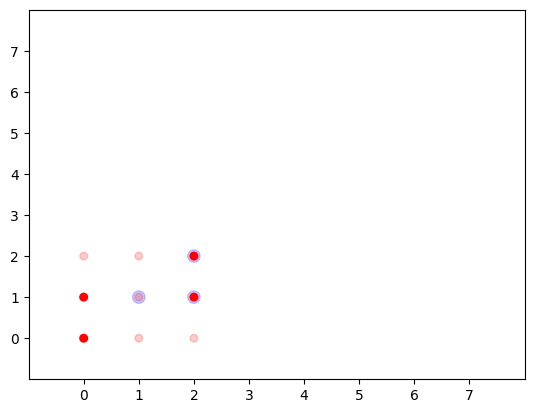

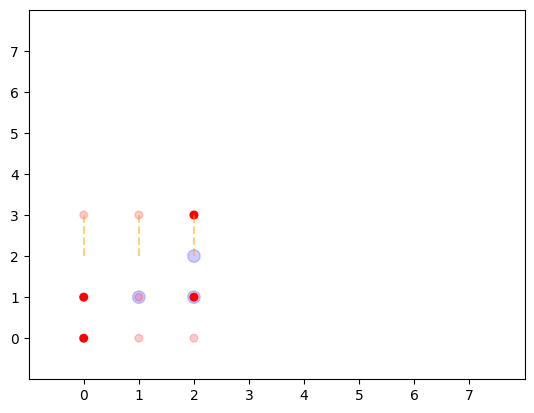

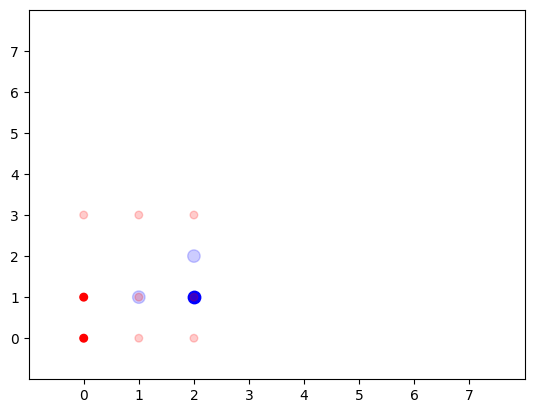

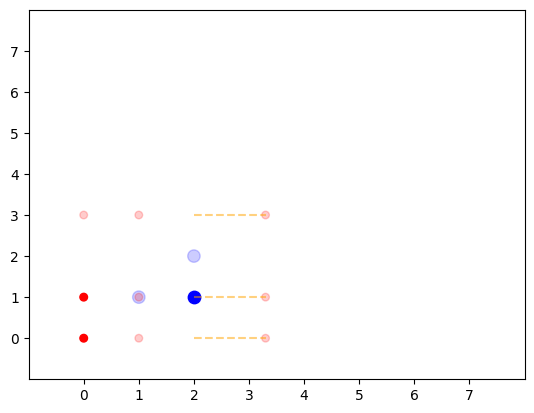

In [45]:
device = DPQA(aod_rows=3,
              aod_cols=3,
              slm_positions_xy=[(1, 1), (2, 1), (2, 2)],
              max_dim_x=8,
              max_dim_y=8,
              rydberg_radius=0.3,
              trap_transfer_radius=0.01)

aod_qubits = cirq.LineQubit.range(4)
#aod_qubits = [q1,q2,q3,q4]
aod_qubit_positions = [(0,0), (1,0), (1,2), (2,2)]
device.add_qubits_to_aod_traps(aod_qubits, aod_qubit_positions)

show_current_state(device)

device.move_aod_row_by(aod_row_index=2,
                       offset=1)

show_current_state(device)

#device.move_aod_col_by(aod_col_index=1,
#                       offset=0.7)
device.deactivate_aod_col(aod_col_index=2)

show_current_state(device)

device.move_aod_col_by(aod_col_index=2,
                       offset=1.3)

show_current_state(device)

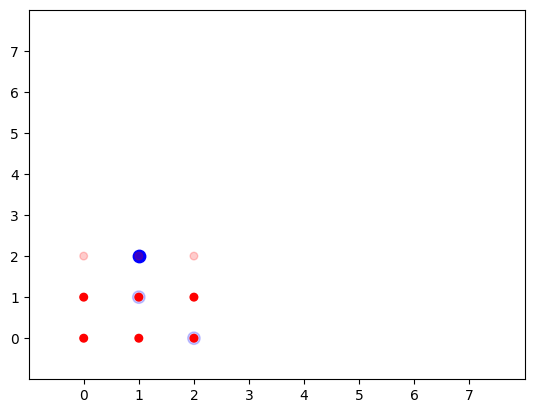

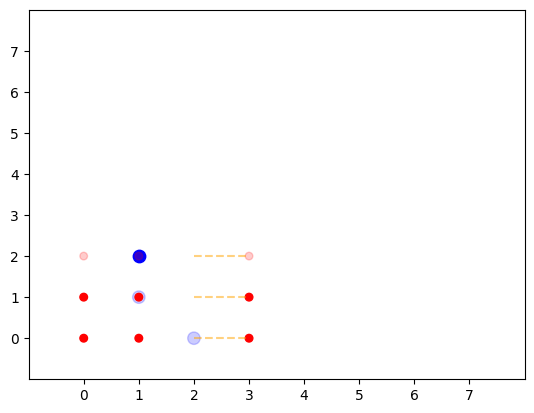

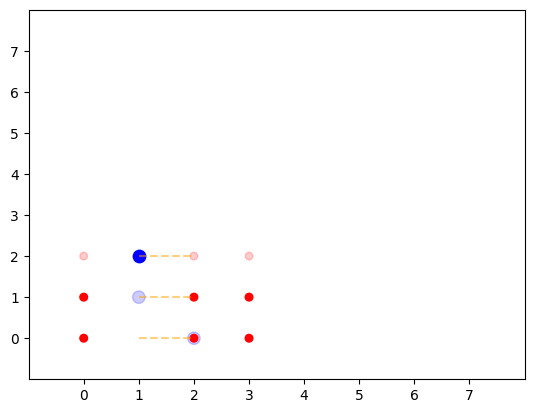

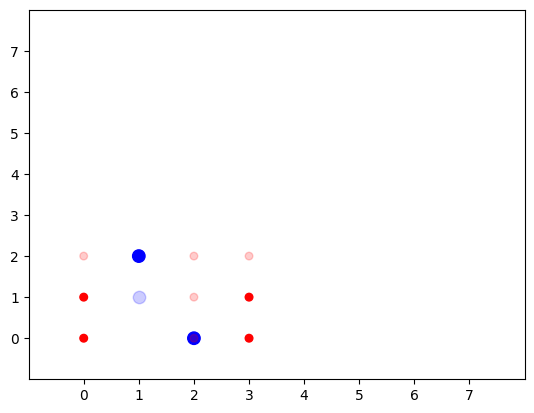

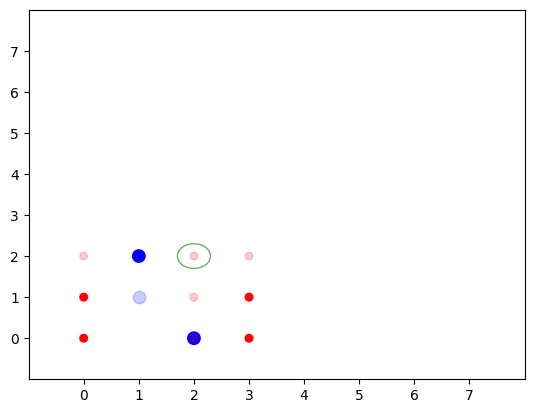

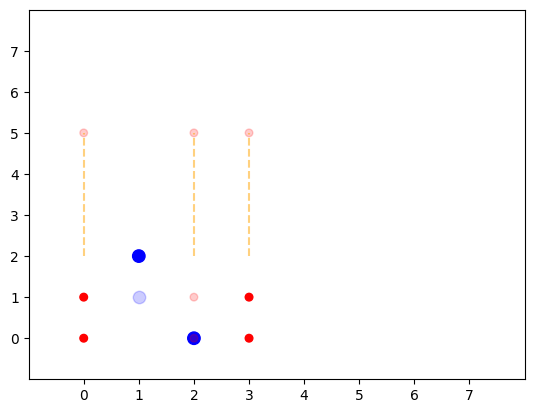

In [46]:
class Instruction:
    pass

class ActivateAODRow(Instruction):
    def __init__(self, row_index):
        self.row_index = row_index

class ActivateAODCol(Instruction):
    def __init__(self, col_index):
        self.col_index = col_index

class DeactivateAODRow(Instruction):
    def __init__(self, row_index):
        self.row_index = row_index

class DeactivateAODCol(Instruction):
    def __init__(self, col_index):
        self.col_index = col_index

class RydbergLaser(Instruction):
    def __init__(self, target_pos, operation):
        self.target_pos = target_pos
        self.operation = operation

class MoveAODRow(Instruction):
    def __init__(self, row_index, offset):
        self.row_index = row_index
        self.offset = offset

class MoveAODCol(Instruction):
    def __init__(self, col_index, offset):
        self.col_index = col_index
        self.offset = offset

class Initialize(Instruction):
    def __init__(self, aod_qubits, aod_qubit_positions_rowcol, slm_qubits, slm_trap_indices):
        assert(len(list(aod_qubits)) == len(list(aod_qubit_positions_rowcol)))
        assert(len(list(slm_qubits)) == len(list(slm_trap_indices)))
        self.aod_qubits = aod_qubits
        self.aod_qubit_positions_rowcol = aod_qubit_positions_rowcol
        self.slm_qubits = slm_qubits
        self.slm_trap_indices = slm_trap_indices

class DrawState(Instruction):
    pass


def execute_instructions(dpqa_device, instructions):
        for inst in instructions:
            assert(isinstance(inst, Instruction))
            if isinstance(inst, ActivateAODRow):
                dpqa_device.activate_aod_row(inst.row_index)
            elif isinstance(inst, ActivateAODCol):
                dpqa_device.activate_aod_col(inst.col_index)
            elif isinstance(inst, DeactivateAODRow):
                dpqa_device.deactivate_aod_row(inst.row_index)
            elif isinstance(inst, DeactivateAODCol):
                dpqa_device.deactivate_aod_col(inst.col_index)
            elif isinstance(inst, RydbergLaser):
                dpqa_device.rydberg_interaction_on_position(inst.target_pos, inst.operation)
            elif isinstance(inst, MoveAODRow):
                dpqa_device.move_aod_row_by(inst.row_index, inst.offset)
            elif isinstance(inst, MoveAODCol):
                dpqa_device.move_aod_col_by(inst.col_index, inst.offset)
            elif isinstance(inst, Initialize):
                dpqa_device.add_qubits_to_aod_traps(inst.aod_qubits, inst.aod_qubit_positions_rowcol)
                dpqa_device.add_qubits_to_slm_traps(inst.slm_qubits, inst.slm_trap_indices)
            elif isinstance(inst, DrawState):
                show_current_state(dpqa_device)
            else:
                # unknown instruction
                pass
            show_current_state(dpqa_device)


test_device = DPQA(
    aod_rows=3,
    aod_cols=3,
    slm_positions_xy=[(1,1), (1,2), (2, 0)],
    max_dim_x=8,
    max_dim_y=8,
    rydberg_radius=0.3,
    trap_transfer_radius=0.01
)

instructions = [
    Initialize(
        aod_qubits=cirq.LineQubit.range(6),
        aod_qubit_positions_rowcol=[(0,0), (0,1), (0,2),
                                    (1,0), (1,1), (1,2)],
        slm_qubits=[cirq.LineQubit.range(6, 7)],
        slm_trap_indices=[1]
    ),
    MoveAODCol(2, 1),
    MoveAODCol(1, 1),
    DeactivateAODCol(1),
    RydbergLaser((2,2), "some operation"),
    MoveAODRow(2, 3),
]

execute_instructions(test_device, instructions)
